# Task 2
## Prediction of m6A sites in all SG-NEx direct RNA-Seq samples 
<ul>
<li> Predict m6A RNA modifications in all samples from the SG-NEx data using our own method </li>
<li> Describe the results and compare them across the different cell lines </li>
<li> Summarise and visualise your observations </li>
</ul>

<b>Submission</b>: Describe the results and compare them across the different cell lines. Summarise and visualise your observations.

# Importing modules and functions

In [16]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import joblib
import numpy as np
import torch
import torch.nn as nn
import sys
import os

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

In [2]:
%run "../code/data_pre_process.py"

In [3]:
%run "../code/feature_eng_pipeline.py"

# Creating a Task 2 original merged dataset 
## Loading and processing the dataset 
## TO run when agg_task2_merged.csv not created.

In [4]:
# Takes about 5 minutes to load 
# A549 Lung cell line 
a549_rep5_df = pd.read_csv("../dataset/CSV/A549_replicate5_data.csv") # change input path accordingly 
a549_rep6_df = pd.read_csv("../dataset/CSV/A549_replicate6_data.csv")

# HCT116 Colon cell line
hct116_rep3_df = pd.read_csv("../dataset/CSV/HCT116_replicate3_data.csv")
hct116_rep3_run4_df = pd.read_csv("../dataset/CSV/HCT116_replicate3_run4_data.csv")
hct116_rep4_run3_df = pd.read_csv("../dataset/CSV/HCT116_replicate4_run3_data.csv")

# HepG2 Liver cell line
hepg2_rep5_df = pd.read_csv("../dataset/CSV/hepG2_replicate5_data.csv")
hepg2_rep6_df = pd.read_csv("../dataset/CSV/hepG2_replicate6_data.csv")

# K562 Leukocytes cell line
k562_rep4_df = pd.read_csv("../dataset/CSV/k562_replicate4_data.csv")
k562_rep5_df = pd.read_csv("../dataset/CSV/k562_replicate5_data.csv")
k562_rep6_df = pd.read_csv("../dataset/CSV/k562_replicate6_data.csv")

# MCF7 Breast cell line
mcf7_rep3_df = pd.read_csv("../dataset/CSV/mcf7_replicate3_data.csv")
mcf7_rep4_df = pd.read_csv("../dataset/CSV/mcf7_replicate4_data.csv")

# List of orig df 
orig_df_list = [a549_rep5_df, a549_rep6_df, hct116_rep3_df, hct116_rep3_run4_df, hct116_rep4_run3_df, hepg2_rep5_df,
                hepg2_rep6_df, k562_rep4_df, k562_rep5_df, k562_rep6_df, mcf7_rep3_df, mcf7_rep4_df ]

Aggregated dataset based on mean 

In [5]:
# A549 Lung cell line
a549_df = data_agg_mean(pd.concat([a549_rep5_df, a549_rep6_df], axis = 0))

# HCT116 Colon cell line
hct116_df = data_agg_mean(pd.concat([hct116_rep3_df, hct116_rep3_run4_df, hct116_rep4_run3_df], axis = 0))

# HepG2 Liver cell line
hepg2_df = data_agg_mean(pd.concat([hepg2_rep5_df, hepg2_rep6_df], axis = 0))

# K562 Leukocytes cell line
k562_df = data_agg_mean(pd.concat([k562_rep4_df, k562_rep5_df, k562_rep6_df], axis = 0))

# MCF7 Breast cell line
mcf7_df = data_agg_mean(pd.concat([mcf7_rep3_df, mcf7_rep4_df], axis = 0))

# List of agg df
agg_df_list = [a549_df, hct116_df, hepg2_df, k562_df, mcf7_df]

In [6]:
cell_line_name = ['A549', 'HCT116', 'HEPG2', 'K562', 'MCF7']
agg_df_list[0]["cell_line_name"] = cell_line_name[0]
agg_merged_df = agg_df_list[0]
for i in range(1, len(agg_df_list)):
    agg_df_list[i]["cell_line_name"] = cell_line_name[i]
    agg_merged_df = pd.concat([agg_merged_df, agg_df_list[i]], axis = 0)

agg_merged_df.to_csv("../dataset/agg_task2_merged.csv", index = False)

In [7]:
# Check
total_count = 0
for df in agg_df_list:
    total_count += len(df)
print(total_count)

assert total_count == len(agg_merged_df), "Please check the merge of raw data."

9733664


# Creating Task 2 predicted dataset
## TO run when pred_merged.csv not written

In [8]:
a549_pred_df= pd.read_csv("../code/prediction/ModNet_predict_on_a549.csv") # transcript_id | transcript_position | score
hct116_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_hct116.csv")
hepg2_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_hepg2.csv")
k562_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_k562.csv")
mcf7_pred_df = pd.read_csv("../code/prediction/ModNet_predict_on_mcf7.csv")

pred_list = [a549_pred_df, hct116_pred_df, hepg2_pred_df, k562_pred_df, mcf7_pred_df]

In [9]:
cell_line_name = ['A549', 'HCT116', 'HEPG2', 'K562', 'MCF7']
pred_list[0]["cell_line_name"] = cell_line_name[0]
pred_df = pred_list[0]
for i in range(1, len(agg_df_list)):
    pred_list[i]["cell_line_name"] = cell_line_name[i]
    pred_df = pd.concat([pred_df, pred_list[i]], axis = 0)

pred_df.to_csv("../dataset/pred_merged.csv", index = False)

In [10]:
# Check
total_count = 0
for df in pred_list:
    total_count += len(df)
print(total_count)

assert total_count == len(pred_df), "Please check the merge of raw data."

9733664


# Descriptive analytics 

In [22]:
agg_merged_df = pd.read_csv("../dataset/agg_task2_merged.csv")
pred_df = pd.read_csv("../dataset/pred_merged.csv")
print(f"Size of agg_merged_df: {len(agg_merged_df)}\nSize of pred_df: {len(pred_df)}")

Size of agg_merged_df: 9733664
Size of pred_df: 9733664


In [11]:
agg_merged_df.columns

Index(['transcript_name', 'json_position', 'nucleotide_seq',
       'dwelling_time_min1', 'sd_min1', 'mean_min1', 'dwelling_time', 'sd',
       'mean', 'dwelling_time_plus1', 'sd_plus1', 'mean_plus1',
       'dwelling_time_merged', 'sd_merged', 'mean_merged', 'cell_line_name'],
      dtype='object')

In [23]:
# obtaining the labels given a specific threshold 
pred_df['labels'] = pred_df['score'].apply(lambda x: 1 if x >= 0.7 else 0)
pred_df.columns

Index(['transcript_id', 'transcript_position', 'score', 'cell_line_name',
       'labels'],
      dtype='object')

In [24]:
combined_df = pd.merge(agg_merged_df, pred_df, how = 'inner', left_on = ['transcript_name', 'json_position', 'cell_line_name'], right_on = ['transcript_id', 'transcript_position', 'cell_line_name'])
print(len(combined_df))

9733664


In [25]:
combined_df = combined_df.drop(['transcript_name', 'json_position'], axis = 1)
combined_df.columns

Index(['nucleotide_seq', 'dwelling_time_min1', 'sd_min1', 'mean_min1',
       'dwelling_time', 'sd', 'mean', 'dwelling_time_plus1', 'sd_plus1',
       'mean_plus1', 'dwelling_time_merged', 'sd_merged', 'mean_merged',
       'cell_line_name', 'transcript_id', 'transcript_position', 'score',
       'labels'],
      dtype='object')

### Line graph to show the change in count of predicted label 1 against different threshold

In [6]:
pred_df = pd.read_csv("../dataset/pred_merged.csv")
thresholds = list(np.arange(0.1, 1.1, 0.1))
thresholds_name_list = []
y = 1
for i in thresholds:
    pred_df[f"{y}"] = pred_df['score'].apply(lambda x: 1 if x >= i else 0)
    thresholds_name_list.append(f"{y}")
    y += 1

melt_df = pred_df.melt(id_vars = ['cell_line_name'],
                       value_vars = thresholds_name_list,
                       var_name = "threshold")


In [7]:
melt_df["threshold"] = melt_df["threshold"].astype(int)/10
print(melt_df)

         cell_line_name  threshold  value
0                  A549        0.1      0
1                  A549        0.1      0
2                  A549        0.1      0
3                  A549        0.1      0
4                  A549        0.1      0
...                 ...        ...    ...
97336635           MCF7        1.0      0
97336636           MCF7        1.0      0
97336637           MCF7        1.0      0
97336638           MCF7        1.0      0
97336639           MCF7        1.0      0

[97336640 rows x 3 columns]


In [8]:
count_df = melt_df.groupby(['cell_line_name', 'threshold'])['value'].apply(lambda x: (x == 1).sum()).reset_index()
print(count_df)

   cell_line_name  threshold   value
0            A549        0.1  146157
1            A549        0.2  136185
2            A549        0.3  129929
3            A549        0.4  125052
4            A549        0.5  120797
5            A549        0.6  116627
6            A549        0.7  112216
7            A549        0.8  107080
8            A549        0.9   99612
9            A549        1.0   14819
10         HCT116        0.1  205890
11         HCT116        0.2  192519
12         HCT116        0.3  184065
13         HCT116        0.4  177413
14         HCT116        0.5  171399
15         HCT116        0.6  165597
16         HCT116        0.7  159505
17         HCT116        0.8  152427
18         HCT116        0.9  142114
19         HCT116        1.0   22808
20          HEPG2        0.1  165262
21          HEPG2        0.2  153766
22          HEPG2        0.3  146584
23          HEPG2        0.4  140980
24          HEPG2        0.5  136013
25          HEPG2        0.6  131167
2

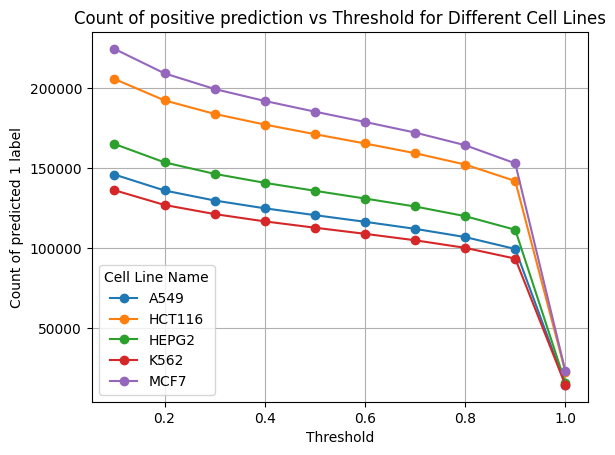

In [9]:
for cell_line in count_df['cell_line_name'].unique():
    subset = count_df[count_df['cell_line_name'] == cell_line]
    plt.plot(subset['threshold'], subset['value'], marker='o', label=cell_line)

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Count of predicted 1 label')
plt.title('Count of positive prediction vs Threshold for Different Cell Lines')
plt.legend(title='Cell Line Name')
plt.grid()

# Show the plot
plt.show()

In [1]:
import pandas as pd
import numpy as np
pred_df = pd.read_csv("../dataset/pred_merged.csv")
thresholds = list(np.arange(0.8, 1.01, 0.01))
thresholds_name_list = []
y = 80
for i in thresholds:
    pred_df[f"{y}"] = pred_df['score'].apply(lambda x: 1 if x >= i else 0)
    thresholds_name_list.append(f"{y}")
    y += 1

melt_df = pred_df.melt(id_vars = ['cell_line_name'],
                       value_vars = thresholds_name_list,
                       var_name = "threshold")

In [2]:
melt_df["threshold"] = melt_df["threshold"].astype(int)/100
print(melt_df)

          cell_line_name  threshold  value
0                   A549        0.8      0
1                   A549        0.8      0
2                   A549        0.8      0
3                   A549        0.8      0
4                   A549        0.8      0
...                  ...        ...    ...
204406939           MCF7        1.0      0
204406940           MCF7        1.0      0
204406941           MCF7        1.0      0
204406942           MCF7        1.0      0
204406943           MCF7        1.0      0

[204406944 rows x 3 columns]


In [3]:
count_df = melt_df.groupby(['cell_line_name', 'threshold'])['value'].apply(lambda x: (x == 1).sum()).reset_index()
print(count_df)

    cell_line_name  threshold   value
0             A549       0.80  107080
1             A549       0.81  106477
2             A549       0.82  105894
3             A549       0.83  105261
4             A549       0.84  104573
..             ...        ...     ...
100           MCF7       0.96  139875
101           MCF7       0.97  136072
102           MCF7       0.98  130850
103           MCF7       0.99  122391
104           MCF7       1.00       0

[105 rows x 3 columns]


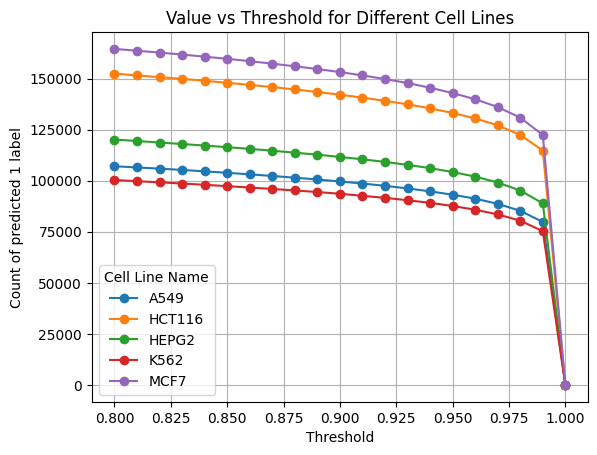

In [ ]:
import matplotlib.pyplot as plt
for cell_line in count_df['cell_line_name'].unique():
    subset = count_df[count_df['cell_line_name'] == cell_line]
    plt.plot(subset['threshold'], subset['value'], marker='o', label=cell_line)

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Count of predicted 1 label')
plt.title('Count of prediction vs Threshold for Different Cell Lines')
plt.legend(title='Cell Line Name')
plt.grid()

# Show the plot
plt.show()


### Bar graphs to show the number of unique (transcripts, position) for each cell line

In [14]:
df = combined_df[['cell_line_name', 'transcript_id', 'transcript_position']].drop_duplicates()
final_count = df.groupby('cell_line_name').size().reset_index(name = "count")
print(final_count)

  cell_line_name    count
0           A549  1632577
1         HCT116  1963526
2          HEPG2  1879601
3           K562  1559321
4           MCF7  2698639


Text(0.5, 1.0, 'Number of unique transcript names at each cell line')

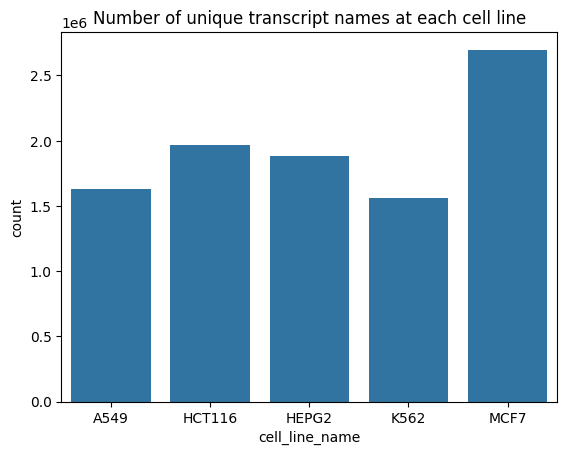

In [17]:
sns.barplot(data = final_count, x = 'cell_line_name', y = 'count')
plt.title("Number of unique transcript names at each cell line")

# Higher number of transcript counts in a cell line signifies greater complexity in a gene expression 

### Bar graphs to show the number of unique (5mers, position) at each cell line 

In [16]:
ns_df = combined_df[['cell_line_name', 'nucleotide_seq', 'transcript_position']].drop_duplicates()
ns_final_count = ns_df.groupby('cell_line_name').size().reset_index(name = "count")
print(ns_final_count)

  cell_line_name   count
0           A549  891555
1         HCT116  980007
2          HEPG2  960471
3           K562  851985
4           MCF7  920025


Text(0.5, 1.0, 'Number of unique 5-mers at each cell line')

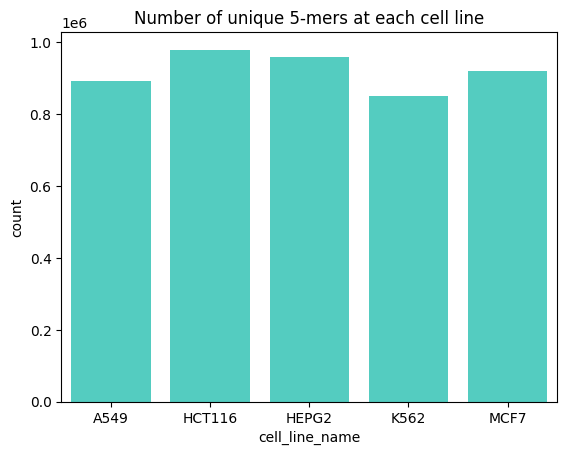

In [17]:
sns.barplot(data = ns_final_count, x = 'cell_line_name', y = 'count', color = "turquoise")
plt.title("Number of unique 5-mers at each cell line")

### Finding the difference in dwelling time for the -1 position, 0 position and +1 position.

<Axes: xlabel='variable', ylabel='value'>

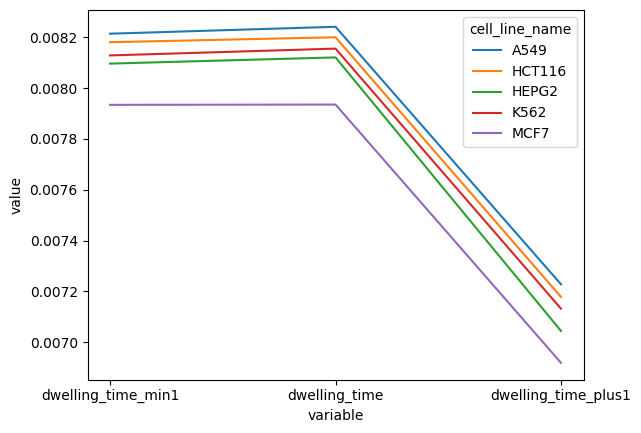

In [18]:
difference_df = combined_df 
difference_df = difference_df.groupby("cell_line_name")[["dwelling_time_min1", "dwelling_time", "dwelling_time_plus1"]].mean().reset_index()
difference_df = difference_df.melt(id_vars = "cell_line_name",
                                   value_vars = ["dwelling_time_min1", "dwelling_time", "dwelling_time_plus1"],
                                   )
sns.lineplot(data = difference_df, x = 'variable', y = 'value', hue = 'cell_line_name')

### Determining the percentage of predicted 0 and 1 labels in each cell line.

In [26]:
remove_dup_df = combined_df.drop_duplicates(keep=False)
final_df = remove_dup_df.groupby(['cell_line_name', 'labels'])['transcript_id'].nunique().reset_index()
total_count = final_df.groupby('cell_line_name')['transcript_id'].transform('sum')
final_df['percentage'] = (final_df['transcript_id']/total_count) * 100
print(final_df)

  cell_line_name  labels  transcript_id  percentage
0           A549       0          47049   59.424811
1           A549       1          32125   40.575189
2         HCT116       0          57057   59.100702
3         HCT116       1          39485   40.899298
4          HEPG2       0          52703   59.906792
5          HEPG2       1          35272   40.093208
6           K562       0          53143   60.935422
7           K562       1          34069   39.064578
8           MCF7       0          89718   60.783317
9           MCF7       1          57885   39.216683


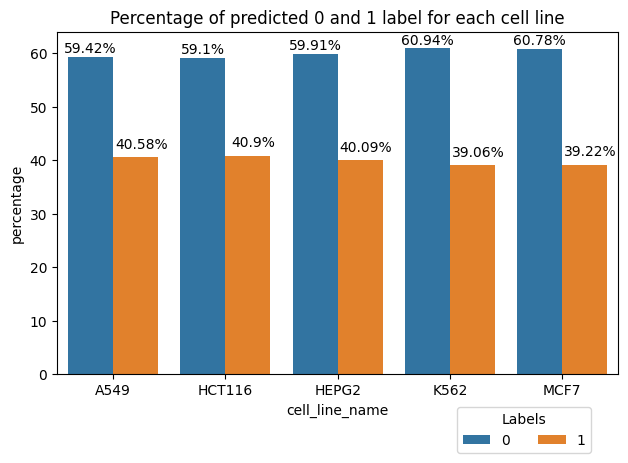

In [28]:
barplot = sns.barplot(data = final_df, x = 'cell_line_name', y = 'percentage', hue = 'labels')
for index, row in final_df.iterrows():
    # Adjust x and y positions as needed
    if index % 2 == 0:
        x_pos = index % 2  + (index // 2) -0.2 # Offset for bar position
        y_pos = row['percentage'] + 0.2 # Position slightly above the bar
        barplot.text(x_pos, y_pos, f"{round(row['percentage'], 2)}%", 
                    ha='center', va='bottom')
    else:
        x_pos = (index-0.75)% 2  + ((index -0.7)// 2)  # Offset for bar position
        y_pos = row['percentage'] + 1 # Position slightly above the bar
        barplot.text(x_pos, y_pos, f"{round(row['percentage'], 2)}%", 
                    ha='center', va='bottom')

plt.title("Percentage of predicted 0 and 1 label for each cell line")
plt.legend(title='Labels', loc='lower left', bbox_to_anchor=(0.7, -0.25), ncol=2)
plt.tight_layout()
plt.show()

### Determining if there is any significant difference in dwelling time/ mean. sd across different cell line and between predicted 0 and 1

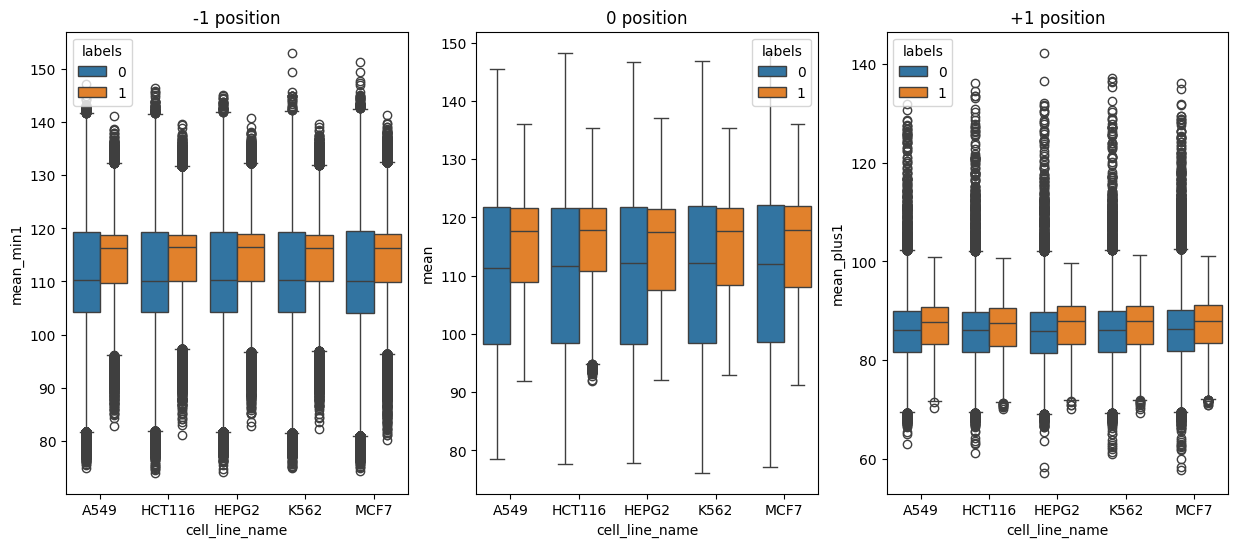

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'mean_min1', data = combined_df, hue = 'labels', ax = ax[0])
ax[0].set_title("-1 position")

sns.boxplot(x = 'cell_line_name', y = 'mean', data = combined_df, hue = 'labels', ax = ax[1])
ax[1].set_title("0 position")

sns.boxplot(x = 'cell_line_name', y = 'mean_plus1', data = combined_df, hue = 'labels', ax = ax[2])
ax[2].set_title("+1 position")

plt.show()

Text(0.5, 1.0, '+1 position')

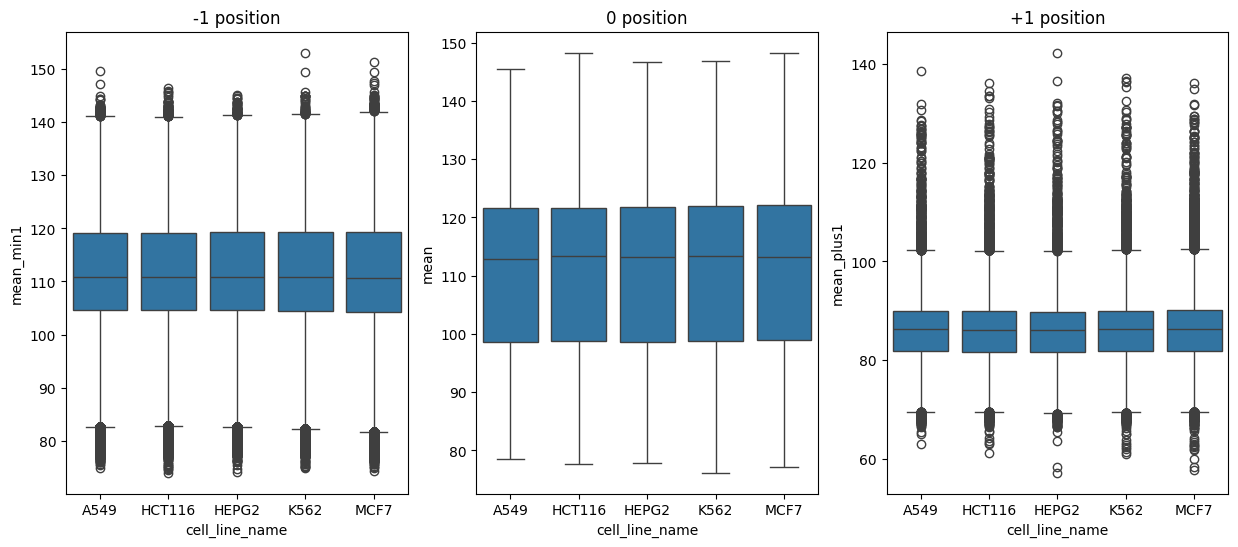

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'mean_min1', data = combined_df, ax = ax[0])
ax[0].set_title("-1 position")

sns.boxplot(x = 'cell_line_name', y = 'mean', data = combined_df, ax = ax[1])
ax[1].set_title("0 position")

sns.boxplot(x = 'cell_line_name', y = 'mean_plus1', data = combined_df, ax = ax[2])
ax[2].set_title("+1 position")

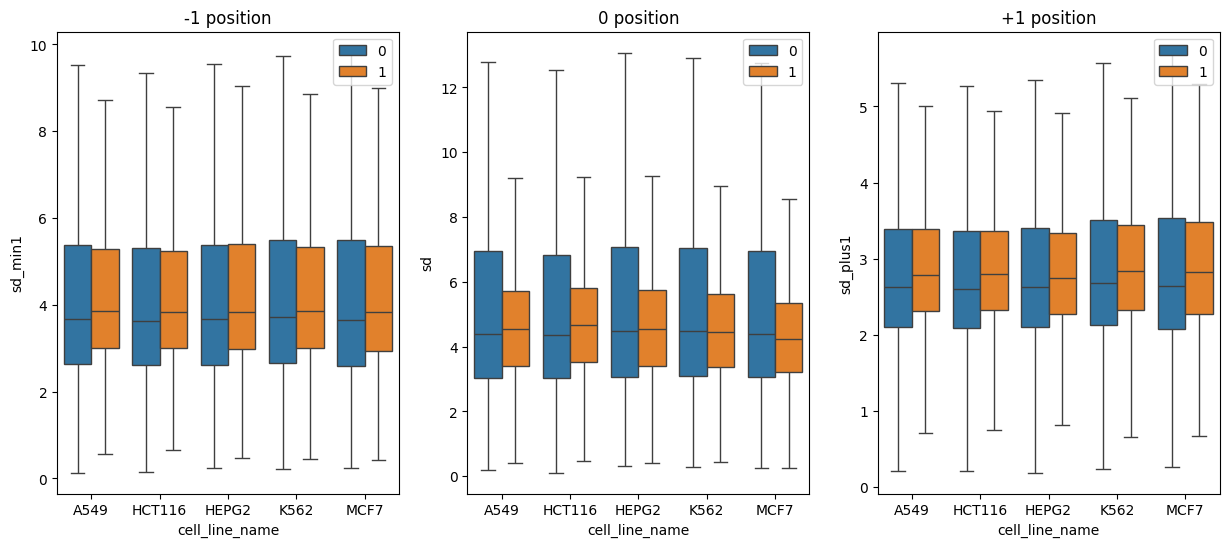

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'sd_min1', data = combined_df, hue = 'labels', showfliers = False, ax = ax[0])
ax[0].legend(loc = 'upper right')
ax[0].set_title("-1 position")

sns.boxplot(x = 'cell_line_name', y = 'sd', data = combined_df, hue = 'labels', showfliers = False, ax = ax[1])
ax[1].legend(loc = 'upper right')
ax[1].set_title("0 position")

sns.boxplot(x = 'cell_line_name', y = 'sd_plus1', data = combined_df, hue = 'labels', showfliers = False, ax = ax[2])
ax[2].legend(loc = 'upper right')
ax[2].set_title("+1 position")

plt.show()

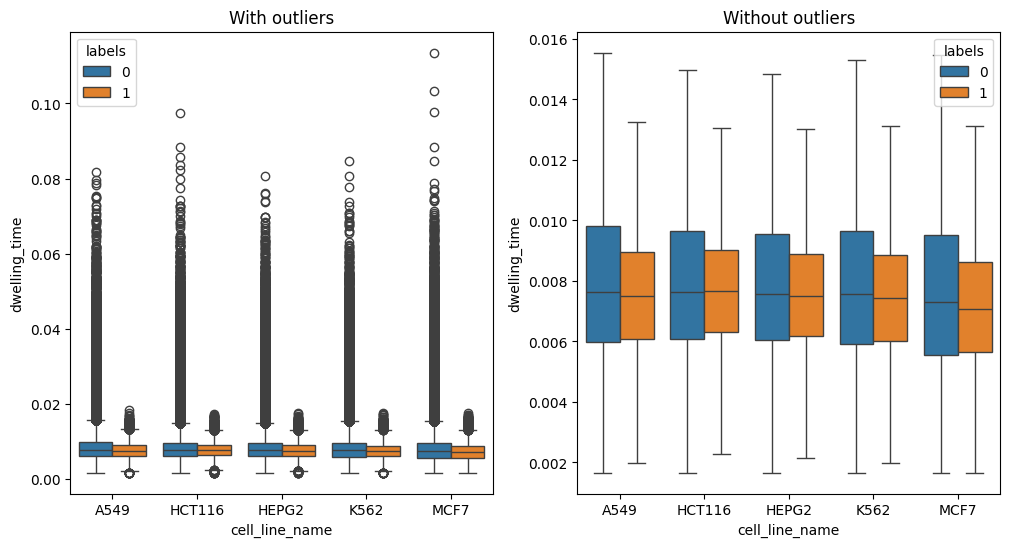

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x = 'cell_line_name', y = 'dwelling_time', data = combined_df, hue = 'labels', ax = ax[0])
ax[0].set_title("With outliers")
sns.boxplot(x = 'cell_line_name', y = 'dwelling_time', data = combined_df, hue = 'labels', showfliers = False, ax = ax[1])
ax[1].set_title("Without outliers")
plt.show()

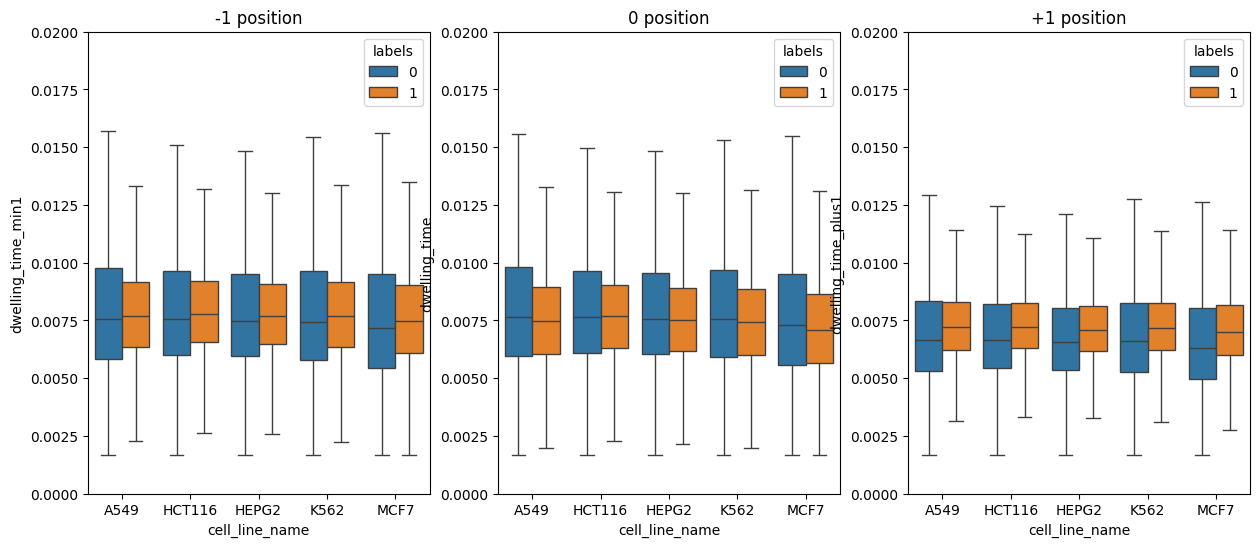

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'dwelling_time_min1', data = combined_df, hue = 'labels', showfliers = False, ax = ax[0])
ax[0].set_title("-1 position")
ax[0].set_ylim(0, 0.020)

sns.boxplot(x = 'cell_line_name', y = 'dwelling_time', data = combined_df, hue = 'labels', showfliers = False, ax = ax[1])
ax[1].set_title("0 position")
ax[1].set_ylim(0, 0.020)

sns.boxplot(x = 'cell_line_name', y = 'dwelling_time_plus1', data = combined_df, hue = 'labels', showfliers = False, ax = ax[2])
ax[2].set_title("+1 position")
ax[2].set_ylim(0, 0.020)
plt.show()

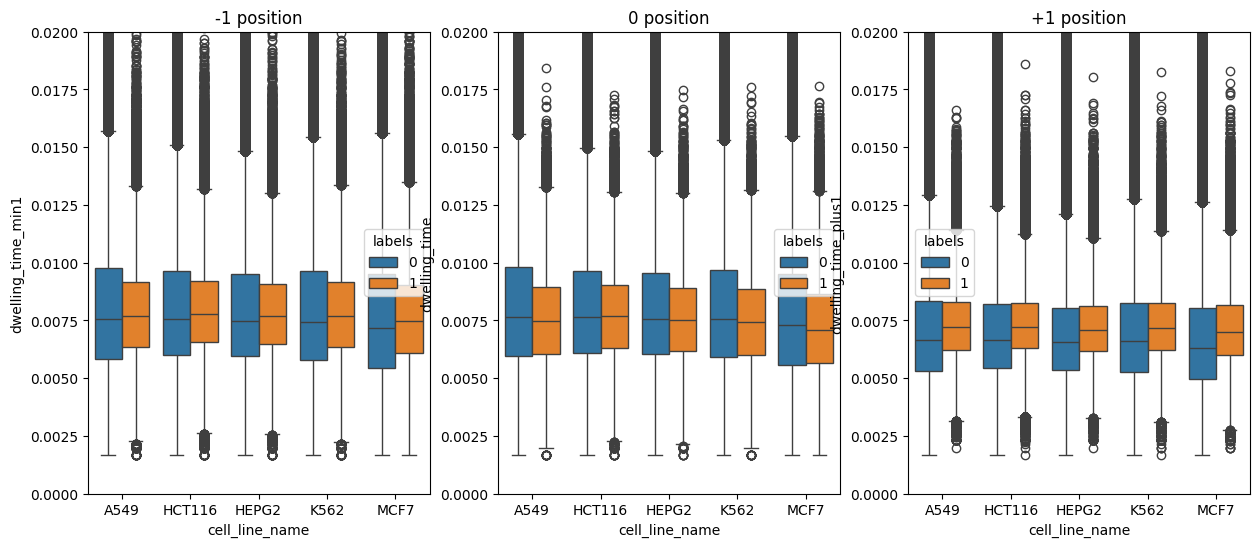

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.boxplot(x = 'cell_line_name', y = 'dwelling_time_min1', data = combined_df, hue = 'labels', ax = ax[0])
ax[0].set_title("-1 position")
ax[0].set_ylim(0, 0.020)

sns.boxplot(x = 'cell_line_name', y = 'dwelling_time', data = combined_df, hue = 'labels', ax = ax[1])
ax[1].set_title("0 position")
ax[1].set_ylim(0, 0.020)

sns.boxplot(x = 'cell_line_name', y = 'dwelling_time_plus1', data = combined_df, hue = 'labels', ax = ax[2])
ax[2].set_title("+1 position")
ax[2].set_ylim(0, 0.020)
plt.show()